# Part 3

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

%matplotlib inline
from finrl.config import INDICATORS

In [48]:
train = pd.read_csv('./data/train_data.csv')
trade = pd.read_csv('./data/trade_data.csv')

train = train.set_index(train.columns[0])
train.index.names = ['']
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']

In [49]:
# Set the corresponding values to 'True' for the algorithms that you want to use
if_using_a2c = True
if_using_ddpg = False
if_using_ppo = False
if_using_sac = False
if_using_td3 = False

In [50]:
trained_a2c = A2C.load('./trained_models/agent_a2c.zip') if if_using_a2c else None
trained_ddpg = DDPG.load('agent_ddpg') if if_using_ddpg else None
trained_ppo = PPO.load('agent_ppo') if if_using_ppo else None
trained_sac = SAC.load('agent_sac') if if_using_sac else None
trained_sac = TD3.load('agent_td3') if if_using_td3 else None

## Out-of-Sample Performance

**Stock Dimension:** The number of stocks to be traded

**State Space:** The window in which the agent will make decisions

In [51]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 4, State Space: 41


In [52]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [53]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold=70, risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [54]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c,
    environment=e_trade_gym) if if_using_a2c else (None, None)

hit end!


## Mean Variance Optimization

MVO will be the baseline to compare the agent's performance

In [55]:
# Helps process data into a form for weight calculation
def process_df_for_mvo(df):
    df = df.sort_values(['date', 'tic'], ignore_index=True)[['date', 'tic', 'close']]
    fst = df
    fst = fst.iloc[0:stock_dimension, :]
    tic = fst['tic'].tolist()

    mvo = pd.DataFrame()

    for k in range(len(tic)):
        mvo[tic[k]] = 0

    for i in range(df.shape[0]//stock_dimension):
        n = df
        n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
        date = n['date'][i*stock_dimension]
        mvo.loc[date] = n['close'].tolist()

    return mvo

# Calculates weights of average return and covariance matrix
def StockReturnsComputing(StockPrice, Rows, Columns):
    StockReturn = np.zeros([Rows-1, Columns])
    for j in range(Columns):     #j: Assets
        for i in range(Rows-1):  # i: Daily Prices
            StockReturn[i, j] = ((StockPrice[i+1, j] - StockPrice[i,j])/StockPrice[i,j]) * 100


    return StockReturn

In [56]:
StockData = process_df_for_mvo(train)
TradeData = process_df_for_mvo(trade)

TradeData.to_numpy()

array([[ 72.1  , 198.749, 117.8  ,  95.045],
       [ 73.496, 200.264, 117.35 ,  95.866],
       [ 74.982, 204.574, 119.75 ,  98.13 ],
       ...,
       [103.85 , 274.239, 290.91 , 262.383],
       [103.71 , 294.103, 299.46 , 269.532],
       [107.59 , 303.522, 318.64 , 272.232]])

In [57]:
# Compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols] = arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

# Compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)

# Set precision for printing results
np.set_printoptions(precision=3, suppress=True)

# Display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [0.089 0.103 0.067 0.172]
Variance-Covariance matrix of returns
 [[2.734 1.616 1.398 2.194]
 [1.616 2.759 1.388 2.341]
 [1.398 1.388 5.408 1.999]
 [2.194 2.341 1.999 7.699]]


## Calculate the Efficient Frontier to get weights

In [58]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(4)])

mvo_weights

array([151940., 452400.,      0., 395660.])

In [59]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)

Initial_Portfolio

array([2142.943, 2289.549,    0.   , 4176.989])

### Test MVO weights on the out-of-sample data

In [60]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=['Mean Var'])

MVO_result

,Mean Var
2020-07-01,1.006555e+06
2020-07-02,1.016442e+06
2020-07-06,1.038953e+06
2020-07-07,1.033818e+06
2020-07-08,1.059806e+06
...,...
2023-04-21,2.009983e+06
2023-04-24,1.998871e+06
2023-04-25,1.946398e+06
2023-04-26,2.021441e+06


## Dow Jones Index as Another Baseline

In [61]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2020-07-01'
TRADE_START_DATE = '2020-07-01'
TRADE_END_DATE = '2023-05-01'

In [62]:
df_dji = YahooDownloader(start_date = TRADE_START_DATE,
                         end_date = TRADE_END_DATE,
                         ticker_list= ['^dji']).fetch_data()

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (712, 8)


In [63]:
df_dji = df_dji[['date', 'close']]
fst_day = df_dji['close'][0]

dji = pd.merge(df_dji['date'], df_dji['close'].div(fst_day).mul(1000000),
               how='outer', left_index=True, right_index=True).set_index('date')

In [64]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0]) if if_using_a2c else None

result = pd.DataFrame()
if if_using_a2c: result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)

## Merge DataFrames and View Results

In [65]:
col_name= []
col_name.append('A2C') if if_using_a2c else None
result.columns = col_name

In [66]:
result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')

In [67]:
result

,A2C,Mean Var,close
date,,,
2020-07-01,1.000000e+06,1.006555e+06,1.000000e+06
2020-07-02,1.000118e+06,1.016442e+06,1.003590e+06
2020-07-06,1.001138e+06,1.038953e+06,1.021452e+06
2020-07-07,1.000526e+06,1.033818e+06,1.006031e+06
2020-07-08,1.001637e+06,1.059806e+06,1.012913e+06
...,...,...,...
2023-04-24,1.918094e+06,1.998871e+06,1.316318e+06
2023-04-25,1.868969e+06,1.946398e+06,1.302929e+06
2023-04-26,1.967825e+06,2.021441e+06,1.294032e+06


<Axes: xlabel='date'>

<Figure size 1600x900 with 0 Axes>

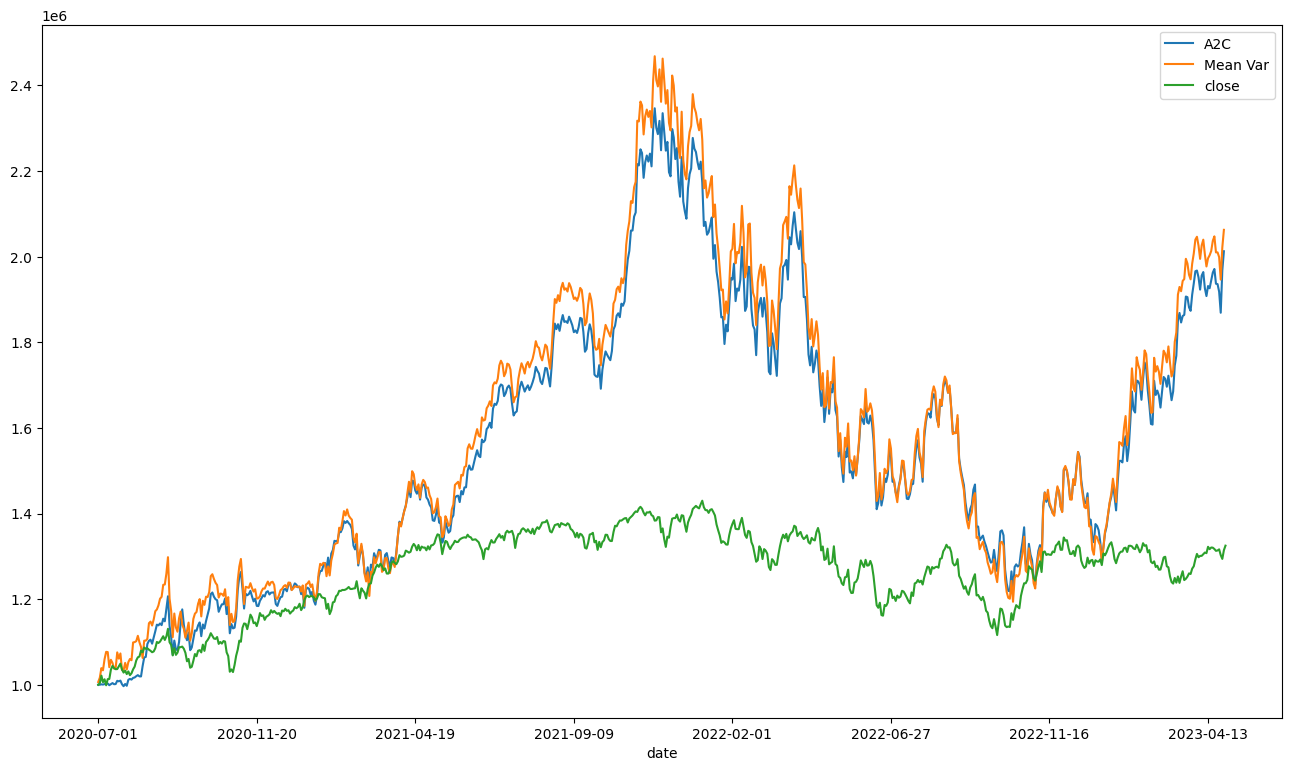

In [68]:
plt.rcParams['figure.figsize'] = (16, 9)
plt.figure()
result.plot()